In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

from sklearn.model_selection import KFold
from six.moves import cPickle as pickle
from keras import regularizers
import os
import platform
from subprocess import check_output

import argparse
import random
import cv2


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls '/content/gdrive/My Drive/cifar10'

data_batch_1  data_batch_3  data_batch_5
data_batch_2  data_batch_4  test_batch


In [0]:
class leNet:
  def initialize_model(height, width, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    # if we are using "channel first" than our first argument of input_shape will change to depth
    if K.image_data_format() == "channels first":
      input_shape = (depth, height, width)

    model.add(Conv2D(20, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(50, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(80, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(110, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    # fully connected layer
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    
    
    # adding Softmax Classifier because we want to classify 10 class
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    return model

In [0]:
def load_pickle(f):
  version = platform.python_version_tuple()
  if version[0] == '2':
    return pickle.load(f)
  elif version[0] == '3':
    return pickle.load(f, encoding='latin1')
  raise ValueError('invalid python version: {}'.format(version))

In [0]:
def load_CIFAR_batch(filename):
  # load single batch of cifar
#   with open(filename, 'rb') as f:
  file = open(filename, 'rb')
  datadict = load_pickle(file)
  X = datadict['data']
  Y = datadict['labels']
  X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('float')
  Y = np.array(Y)
  return X, Y

In [0]:
def load_CIFAR10(ROOT):
  # load all of the cifar
  xs = []
  ys = []
  for b in range(1, 6):
    f = ROOT+'data_batch_'+str(b)
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(ROOT+'test_batch')
  return Xtr, Ytr, Xte, Yte

In [0]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
  # load the raw CIFAR-10 data
  cifar10_dir = '/content/gdrive/My Drive/cifar10/'
  
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  
  # normalize the data: substract the mean image
  # Z-scores
  std = np.std(X_train,axis=(0,1,2,3))
  std = np.std(X_val,axis=(0,1,2,3))
  std = np.std(X_test,axis=(0,1,2,3))
  mean_image = np.mean(X_train, axis=0)
  X_train =(X_train - mean_image)/(std)
  X_val = (X_val - mean_image)/std
  X_test = (X_test - mean_image)/std
  
  return X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
y=y_train
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical( y_test, num_classes=10)
y_val = to_categorical( y_val, num_classes=10)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [0]:
EPOCHS = 5
INIT_LR = 1e-3
BS = 32

# data augmentation
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

# model
model = leNet.initialize_model(width=32, height=32, depth=3, classes=10)
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)

# compile the model
model.compile(loss = 'categorical_crossentropy',
             optimizer=Adam(lr=0.0001, decay = 1e-6),
             metrics = ['accuracy'])

In [22]:
history = model.fit(X_train,
                    y_train,
                   batch_size=128,
                   epochs=10,
                    validation_data = (X_val, y_val)
                   )

Train on 49000 samples, validate on 1000 samples
Epoch 1/10
49000/49000 [==============================] - 260s 5ms/step - loss: 1.2046 - acc: 0.5651 - val_loss: 1.1247 - val_acc: 0.5910
Epoch 2/10
49000/49000 [==============================] - 261s 5ms/step - loss: 1.1774 - acc: 0.5741 - val_loss: 1.0895 - val_acc: 0.6050
Epoch 3/10
49000/49000 [==============================] - 260s 5ms/step - loss: 1.1537 - acc: 0.5846 - val_loss: 1.0909 - val_acc: 0.6150
Epoch 4/10
49000/49000 [==============================] - 260s 5ms/step - loss: 1.1353 - acc: 0.5916 - val_loss: 1.0625 - val_acc: 0.6180
Epoch 5/10
49000/49000 [==============================] - 261s 5ms/step - loss: 1.1143 - acc: 0.6020 - val_loss: 1.0257 - val_acc: 0.6410
Epoch 6/10
49000/49000 [==============================] - 260s 5ms/step - loss: 1.0956 - acc: 0.6045 - val_loss: 1.0197 - val_acc: 0.6410
Epoch 7/10
49000/49000 [==============================] - 260s 5ms/step - loss: 1.0723 - acc: 0.6140 - val_loss: 0.9886 - v

In [23]:
scores = model.evaluate(X_test, y_test)

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

10000/10000 [==============================] - 21s 2ms/step
Loss: 0.950
Accuracy: 0.663


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


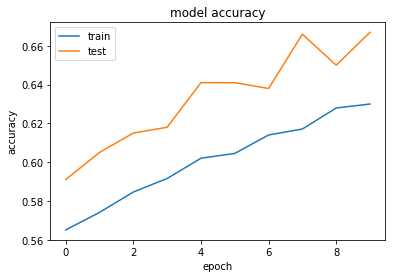

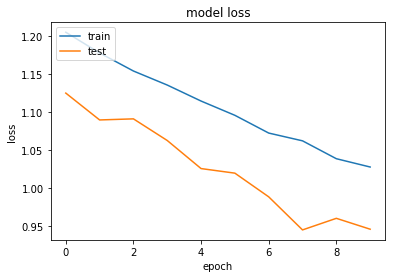

In [24]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
model.summary()

In [0]:
def predict_label(a):
  # a is the number of index for which model predict the max value
  if a == 0:
    p = 'Aeroplane'
  if a == 1:
    p = 'automobile'
  if a == 2:
    p = 'bird'
  if a == 3:
    p = 'cat'
  if a == 4:
    p == 'deer'
  if a == 5:
    p == 'dog'
  if a == 6:
    p == 'frog'
  if a == 7:
    p == 'hourse'
  if a == 8:
    p = 'Ship'
  if a == 9:
    p = 'truck'
  
  return p

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


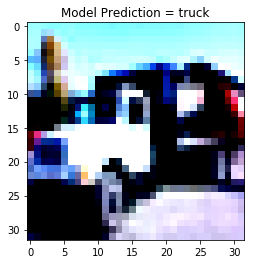

In [26]:
x = np.expand_dims(X_test[45], axis=0)
a = model.predict(x)
maxindex = a.argmax()
p = predict_label(maxindex)

plt.title('Model Prediction = '+p)
plt.imshow(X_test[45])